# Preregistration: Evaluation of Clinical Benefit

Gaylen Fronk  
April 23, 2024

In [ ]:
#| echo: false
study <- params$study
version <- params$version
algorithms <- params$algorithms

In [ ]:
#| message: false
#| warning: false
#| echo: false

# packages for script
library(lme4)

Loading required package: Matrix

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.9
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.1
✔ infer        1.0.6     ✔ tune         1.1.2
✔ modeldata    1.3.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()  masks scales::discard()
✖ tidyr::expand()   masks Matrix::expand()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ tidyr::pack()     masks Matrix::pack()
✖ recipes::step()   masks stats::step()
✖ tidyr::unpack()   masks Matrix::unpack()
✖ recipes::update() masks Matrix::update(), stats::update()
• Learn how to get started at https://www.tidymodels.org/start/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ readr::spec()       masks yardstick::spec()
✖ tidyr::unpack()     masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "bb7bddab14e337e74cb65ad3b94d58a2492d34cd"

In [ ]:
#| message: false
#| warning: false
#| echo: false

# handle conflicts
options(conflicts.policy = "depends.ok")

In [ ]:
#| echo: false

# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- "P:/studydata/match/models"},
        
        # IOS paths
        Darwin = {
          path_models <- "/Volumes/private/studydata/match/models"},
        
        # Linux paths
        Linux = {
          path_models <- "~/mnt/private/studydata/match/models"}
)

In [ ]:
#| echo: false

# chunk defaults
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)

In [ ]:
#| echo: false

# read in d for week 4 model
d_wk4 <- read_csv(file.path(path_models, "pp_hybrid_wk4_outcome", 
                            str_c("aim_2_", version, "_pp_hybrid_wk4_outcome.csv")),
                  show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "first",
    tx_rct == tx_second ~ "second",
    tx_rct == tx_worst ~ "third",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) 

# read in best_config for week 4 model
best_configuration_wk4 <- read_csv(file.path(path_models, "pp_hybrid_wk4_outcome",
                                             str_c("best_config_", version, ".csv")),
                                   show_col_types = FALSE) |> 
  select(algorithm, feature_set, alpha = hp1, lambda = hp2, resample)

# read in d for week 26 model
# d_wk26 <- read_csv(file.path(path_models, "pp_hybrid_wk26_outcome", 
#                         str_c("aim_2_", version, "_pp_hybrid_wk26_outcome.csv")),
#               show_col_types = FALSE) |> 
#   mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
#          outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
#          outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
#          tx_worst = case_when(
#            prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
#            prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
#            prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
#            TRUE ~ NA_character_),
#          tx_second = case_when(
#            tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
#            tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
#            tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
#            tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
#            tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
#            tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
#            TRUE ~ NA_character_)) |> 
#   mutate(tx_rank = case_when(
#     tx_rct == tx_best ~ "first",
#     tx_rct == tx_second ~ "second",
#     tx_rct == tx_worst ~ "third",
#     TRUE ~ NA_character_)) |> 
#   select(subid, starts_with("tx_"), starts_with("prob_"),
#          outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) 

# read in best_config for week 26 model
# best_configuration_wk26 <- read_csv(file.path(path_models, "pp_hybrid_wk26_outcome",
#                                               str_c("best_config_", version, ".csv")),
#                                     show_col_types = FALSE) |> 
#   select(algorithm, feature_set, learning_rate = hp1, tree_depth = hp2, 
#          mtry = hp3, resample)

## Study Overview

### Specific Aims

This project represents a tangible application of the precision mental health paradigm using modern machine learning approaches. This project aims to produce a decision-making tool to select among cigarette smoking cessation treatments for individuals looking to quit smoking.

Cigarette smoking remains a critical and costly public health crisis. Existing treatments are only modestly effective at best. Additionally, treatments are similarly effective at the population level, meaning that even population-level effectiveness cannot guide treatment selection for individuals quitting smoking. Thus, deciding among first-line (i.e., FDA-approved) smoking cessation medications is a specific, objective decision that many individuals who smoke (or their providers) must make. Successful application of the precision mental health paradigm to cigarette smoking cessation would have immediate clinical benefit.

Specifically, this project pursues the following aims:

**AIM 1: Build a machine learning model to guide treatment selection for cigarette smoking cessation.** We will build a machine learning model to predict treatment success (i.e.,7-day point-prevalence abstinence from smoking 4 weeks post-quit) for people who smoke who received one of three cigarette smoking cessation treatments. This model will use clinical features (predictors) from a richly characterized sample of people who smoke from a previously completed randomized controlled trial. The model will produce probabilities of treatment success for each treatment such that it can guide selection of the best treatment for any specific individual.

**AIM 2: Evaluate the clinical benefit of using a treatment selection machine learning model.** Using the best model identified in **AIM 1**, we will identify the treatment for each person that gives them the highest likelihood of abstinence by comparing predicted probabilities of abstinence for each participant for each treatment. We will then evaluate the clinical benefit of this model-based treatment selection approach.

### Data

This project relies on existing data from a completed comparative effectiveness trial by [Baker et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4824537/). Briefly, 1086 individuals who smoke cigarettes were randomized to receive varenicline, combination nicotine replacement therapy (NRT), or nicotine patch to assist with a quit attempt. Individuals were richly characterized at baseline (pre-treatment) with respect to demographic characteristics, mental health, social/environmental variables, physical health, and smoking history. Participants were assessed periodically for biologically confirmed, 7-day point-prevalence abstinence. When abstinence was biologically confirmed (i.e., via exhaled carbon monoxide), individuals were labeled as abstinent; otherwise, individuals were labeled as smoking. Thus, we used predictors from the rich baseline characterization to predict our **primary outcome** of 7-day point-prevalance abstinence at 4 weeks post-quit.

## Analysis Progress at Time of Preregistration

### Completed: Model Building, Selection, & Evaluation

**AIM 1** analyses have been completed: Models using all available data have been fit and selected with nested cross-validation (1 repeat of 10-fold cross-validation in the inner loops, 3 repeats of 10-fold cross-validation in the outer loop). These 30-held out folds (“test sets”) were used to evaluate model performance.

### Completed: Model Performance

Models were evaluated using our primary performance metric, area under the ROC curve (auROC), an index of how well our models discriminate between positive (abstinent) and negative (smoking) cases.

We evaluated model performance in-depth by conducting *Bayesian hierarchical generalized linear models* to estimate the posterior probability distributions and 95% Bayesian credible intervals (CIs) for auROC for our best models from the 30 held-out test sets from nested cross-validation. Below, you can see the posterior probabilities for auROC in held-out folds.

``` python
pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_26"))) |> 
  filter(model == "week_4") |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y + 100, yend = y - 100, x = mean, xend = mean,
                             color = model),
               data = ci_week4) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper, color = model),
               data = ci_week4) +
  scale_y_continuous("Posterior Probability", breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve") +
  theme(legend.position = "none")
```

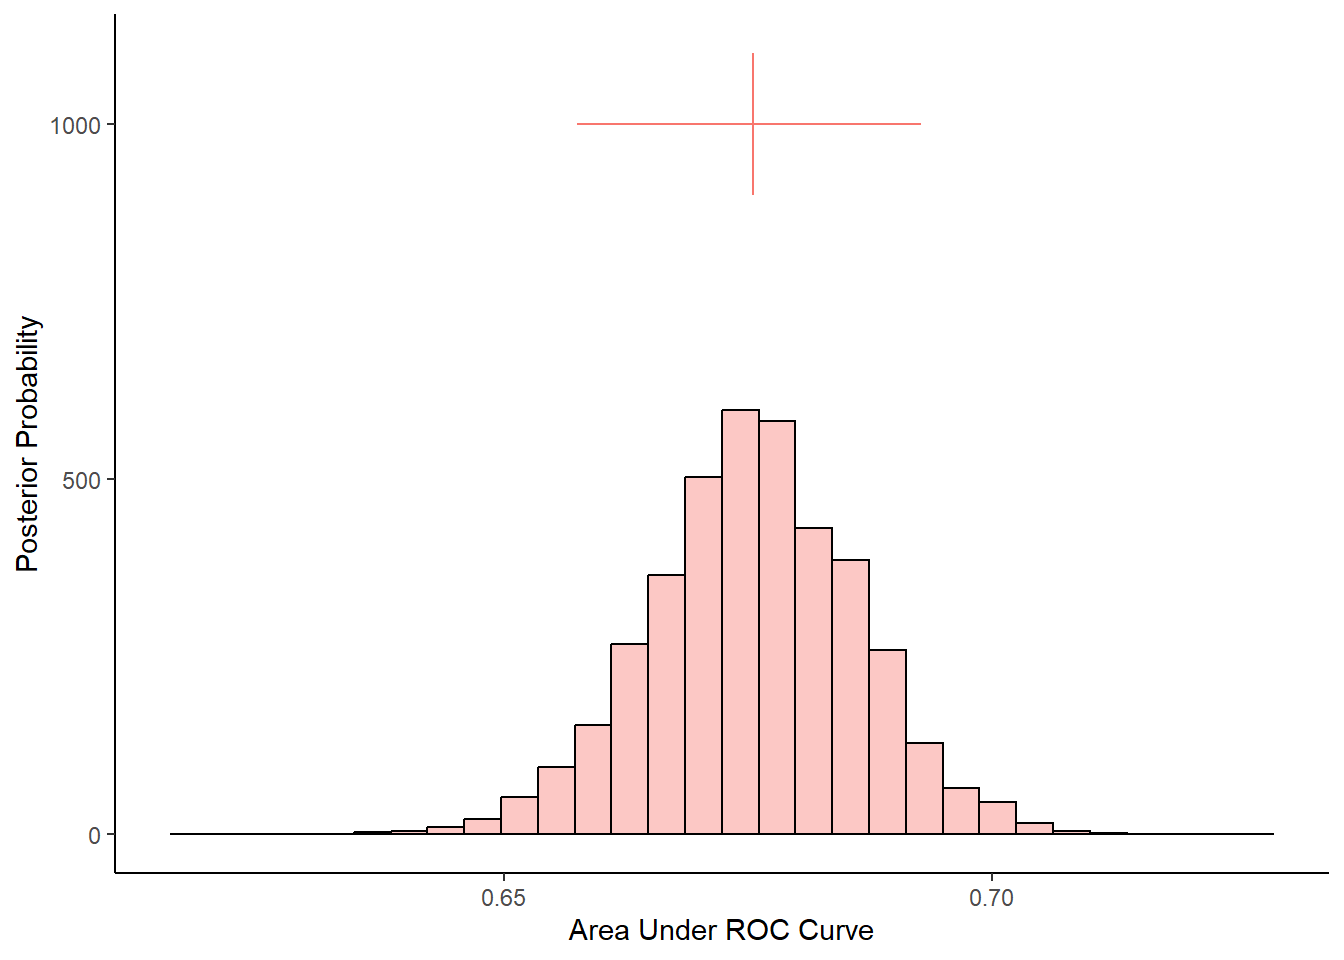

The horizontal line indicates the 95% CIs. The vertical line represents the median posterior probability for auROC. This represents our best estimate for the magnitude of the auROC parameter. The CI does not contain 0.5 (i.e., chance performance), suggesting the model is capturing signal in the data.

### Completed: Fit Final Model

A single, best model was selected with 1 repeat of 10-fold cross-validation in the full dataset.

The best model configuration includes the following:

In [ ]:
#| echo: false
glimpse(best_configuration_wk4)

Rows: 1
Columns: 5
$ algorithm   <chr> "glmnet"
$ feature_set <chr> "item_ordinal"
$ alpha       <dbl> 0.1
$ lambda      <dbl> 0.1326421
$ resample    <chr> "up_1"

-   Selected algorithm was glmnet (xgboost and random forest also considered)

-   Selected feature set was “item_ordinal” indicating that individual items (rather than scale scores) were used, and ordinal scoring was used for ordered data (rather than dummy coding)

-   Selected resampling approach was “up_1” corresponding to upsampling (vs. downsampling or SMOTE) with a ratio of 1:1 (majority:minority class)

-   Values of the hyperparameters alpha and lambda were selected from sensible ranges for each value

### In Progress: AIM 2 Clinical Benefit Analyses

**AIM 2** analyses using this full model are underway. We have used the final model fit in the full dataset to generate three predictions (probabilities, `prob_*`) for each participant by substituting each treatment into the model inputs. Thus, there is one prediction per person per treatment.

In [ ]:
set.seed(82294)
d_wk4 |> 
  select(subid, prob_patch, prob_combo_nrt, prob_varenicline) |> 
  slice_sample(n = 8) |> 
  print_kbl(digits = 3)

The treatment that yields the highest model-predicted probability of abstinence is identified as that participant’s “best” treatment (`tx_best`).

In [ ]:
d_wk4 |> 
  select(subid, tx_best, prob_patch, prob_combo_nrt, prob_varenicline) |> 
  slice_sample(n = 8) |> 
  print_kbl(digits = 3)

The best treatments spanned all three medication options: varenicline, combination nicotine replacement therapy (“combo_nrt”), and nicotine patch (“patch”).

In [ ]:
d_wk4 |> 
  tab(tx_best)

# A tibble: 3 × 3
  tx_best         n  prop
  <chr>       <int> <dbl>
1 combo_nrt     339 0.312
2 patch         193 0.178
3 varenicline   554 0.510

Some participants’ best treatment (`tx_best`) matched what they were randomly assigned in the original trial (`tx_rct`). Other participants may have received what the model identified as their second-best or worst treatment. Thus, participants’ RCT-assigned treatment can be categorized by whether it “matched” their model-assigned treatment (`tx_match`).

In [ ]:
d_wk4 |> 
  select(subid, tx_match, tx_rct, tx_best, tx_second, tx_worst) |> 
  slice_sample(n = 10) |> 
  print_kbl()

Approximately 38% of participants received their model-assigned “best” treatment in the original trial.

In [ ]:
d_wk4 |> 
  tab(tx_match)

# A tibble: 2 × 3
  tx_match     n  prop
  <lgl>    <int> <dbl>
1 FALSE      677 0.623
2 TRUE       409 0.377

At the time of this preregistration, **no analyses have been conducted using these probabilities or model-based treatment assignments.**

## Purpose of Preregistration

The purpose of this document is to **preregister the analyses for evaluating the clinical benefit of this treatment selection model**.

### Outcomes

Our primary analysis will compare the observed outcomes (i.e., abstinence vs. smoking, from the original trial) for people who did or did not receive their best treatment. We will examine these outcomes over the following time points:

-   4 weeks: This served as the outcome for a prediction model. This selection was made so that, in real-world implementation, treatment could be adjusted earlier for individuals for whom treatment is not working.

-   12 weeks: This is end-of-treatment and represents a mid-point between the early (4-week) and later (26-week) outcomes.

-   26 weeks (6 months): This is the gold standard assessment period for smoking cessation treatments and was the primary outcome for the original trial ([Baker et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4824537/)). This duration is often used as a proxy for long-term success.

### Modeling Specifications

We plan to follow a mixed-effects modeling approach using the `blme` package. Specifically, we will fit a partially Bayesian generalized linear model using `bglmer()` with the components listed below. This approach uses regularizing priors to force the estimated random effects variance-covariance matrices away from singularity ([Chung et al., 2013](https://link.springer.com/article/10.1007/s11336-013-9328-2), `blme` package). We would use the default `"nlminbwrap"` optimizer.

To ensure that all proposed analyses are feasible and to specify analyses as precisely as possible, **we conduct these proposed analyses using our data with shuffled outcome variables**. Following preregistration, our analyses will follow this script exactly using our real data.

Our model will have the following components:

1.  Dependent variable: abstinence (vs. smoking; `outcome_rct_num`). Binary outcome with abstinence coded as 1 and smoking coded as 0.

2.  Independent variable: treatment match (`tx_match`). Between-subjects categorical variable with two levels (TRUE or FALSE). This variable will be coded with an orthogonal contrast such that we compare individuals who received their best treatment to individuals who did not.

3.  Independent variable: time (`week`). This variable has repeated measures such that there are three time points for each subject. This variable will be treated as a numeric variable, and it will be log-transformed (natural log) to meet linearity assumptions. Log transformation is appropriate when the shape of the relationship between the raw variable and outcome is asymptotic.

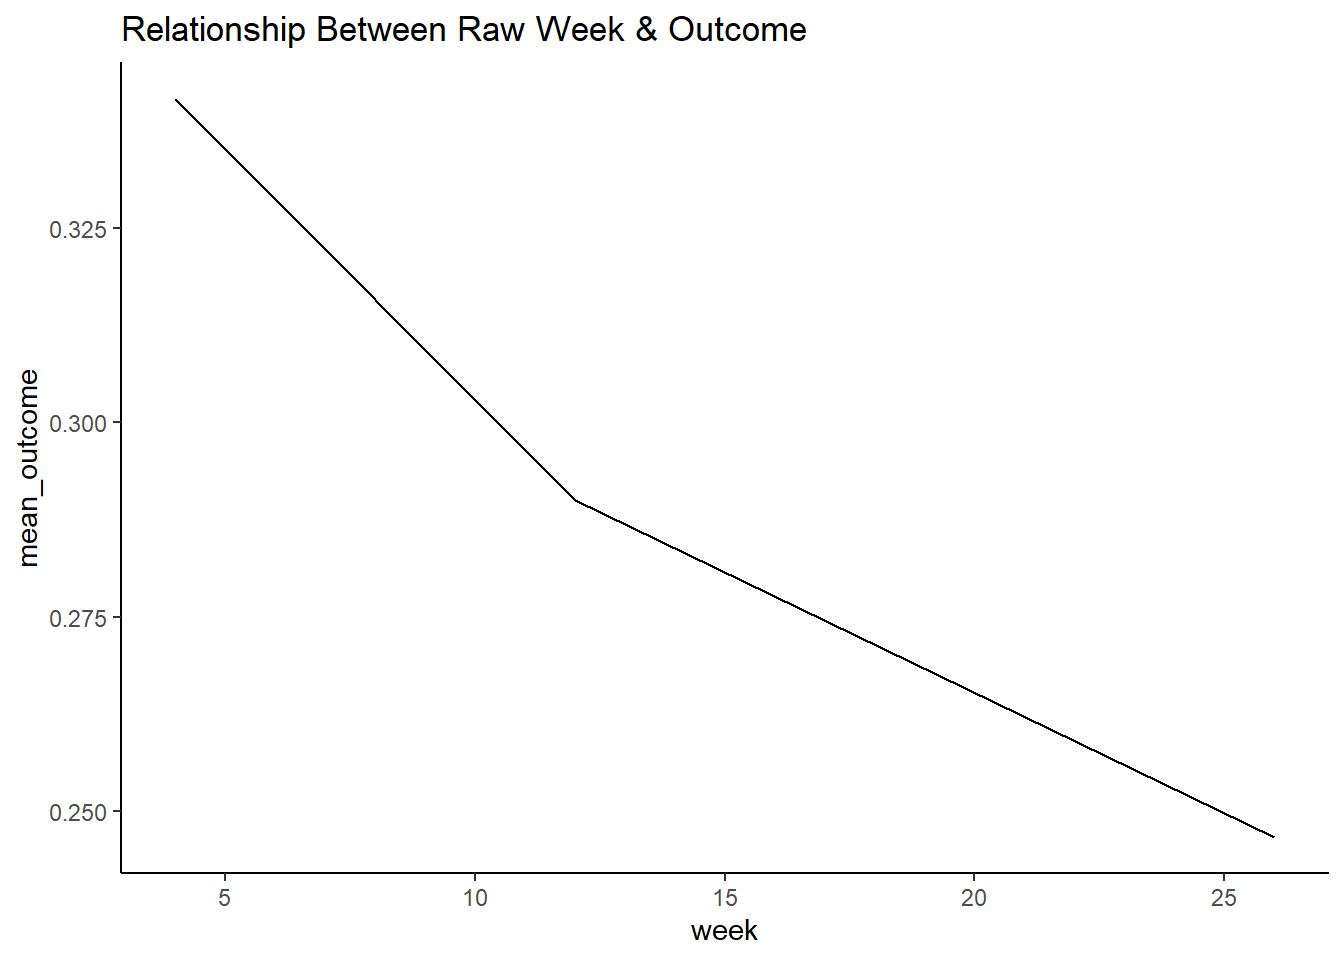

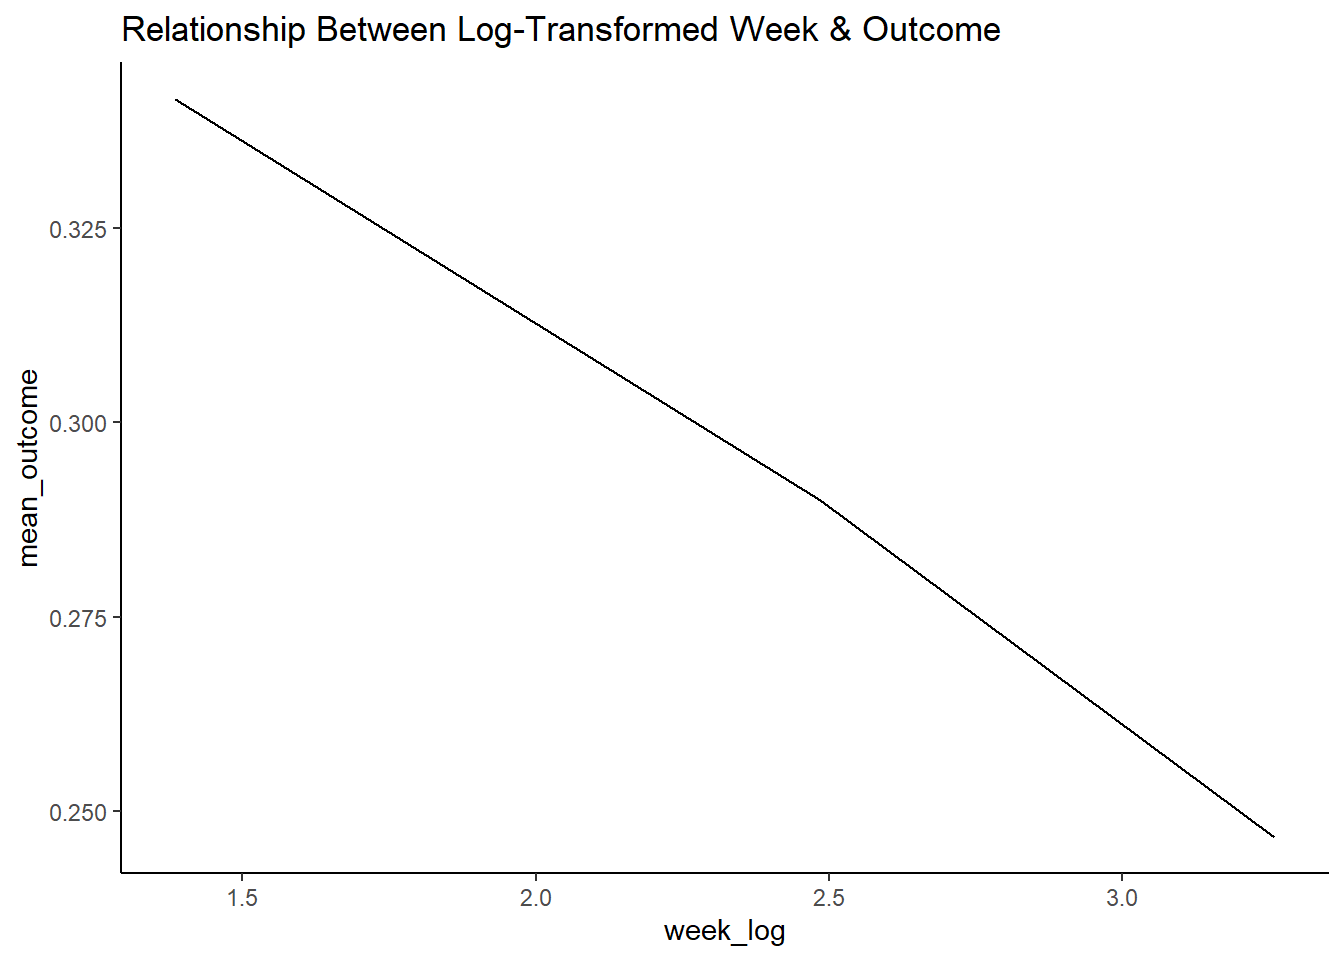

In [ ]:
#| echo: false
d_log_fig <- d_wk4 |> 
  select(subid, outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(week = as.numeric(week)) |> 
  mutate(week_log = log(week)) # default base = e (natural log)

d_log_fig |>
  group_by(week) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) |> 
  ggplot(aes(x = week, y = mean_outcome)) +
  geom_line() +
  ggtitle("Relationship Between Raw Week & Outcome")

1.  Interaction between treatment match and time

2.  Random slope for time (3 repeated observations of time for each subject)

3.  Random intercept

### Focal & Secondary Effects

Our **focal effect** is the effect of treatment match. We predict that individuals who received their best treatment will have improved outcomes compared to individuals who did not.

Our **secondary effects** include:

-   The interaction between treatment match and time. We do not have a directional hypothesis about this interaction.

    -   If this interaction is significant (*p* \< 0.05), we will conduct **follow-up tests** of the simple effect of treatment match at all 3 time points (week 4, week 12, and week 26). These will be general linear models using the `glm` function within the `stats` package.

We plan to report the estimates, test statistics, *p*-values, and confidence intervals for all effects from this model.

## Shuffle Data

To create our shuffled dataset, we randomly sample (without replacement) the treatment match (`tx_match`) variable. This:

-   Breaks any relationship between `tx_match` and the outcome

-   Breaks any interactive effect of `tx_match` and `week` on the outcome

-   Maintains the random effect structure within the `week` variable

In [ ]:
set.seed(72905)
d_shuf <- d_wk4 |> 
  # select only necessary variables
  select(subid, tx_match, 
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  # randomize tx_match variable
  mutate(tx_match = sample(d_wk4$tx_match, nrow(d_wk4), replace = FALSE)) |>
  # pivot to long data format where week is its own variable
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  # correctly class independent variables
  mutate(tx_match = factor(tx_match, 
                           levels = c(FALSE, TRUE)),
         week = as.numeric(week)) |> 
  # log transform week variable per above
  mutate(week_log = log(week)) # default base is e (natural log)

glimpse(d_shuf)

Rows: 3,258
Columns: 5
$ subid           <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 20030…
$ tx_match        <fct> TRUE, TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ week            <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26,…
$ outcome_rct_num <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, …
$ week_log        <dbl> 1.386294, 2.484907, 3.258097, 1.386294, 2.484907, 3.25…

Confirm that data look random

In [ ]:
d_shuf |> 
  group_by(week, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) 

`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.

# A tibble: 6 × 3
# Groups:   week [3]
   week tx_match mean_outcome
  <dbl> <fct>           <dbl>
1     4 FALSE           0.349
2     4 TRUE            0.330
3    12 FALSE           0.290
4    12 TRUE            0.291
5    26 FALSE           0.244
6    26 TRUE            0.252

## Analysis Steps

Set contrasts for treatment match

In [ ]:
c_tx <- contr.helmert(c(FALSE, TRUE))
c_tx[, 1] <- c_tx[, 1] / (max(c_tx[, 1]) - min(c_tx[, 1])) # scale
colnames(c_tx) <- c("best_v_other")
contrasts(d_shuf$tx_match) <- c_tx
contrasts(d_shuf$tx_match)

      best_v_other
FALSE         -0.5
TRUE           0.5

### Primary Model

In [ ]:
model_1 <- blme::bglmer(outcome_rct_num ~ tx_match * week_log + 
                          (1 + week_log | subid),
                        data = d_shuf,
                        family = binomial(link = "logit"),
                        control = glmerControl(optCtrl = list(maxfun = 3e6)))

summary(model_1)

Cov prior  : subid ~ wishart(df = 4.5, scale = Inf, posterior.scale = cov, common.scale = TRUE)
Prior dev  : -2.0001

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [bglmerMod]
 Family: binomial  ( logit )
Formula: outcome_rct_num ~ tx_match * week_log + (1 + week_log | subid)
   Data: d_shuf
Control: glmerControl(optCtrl = list(maxfun = 3e+06))

     AIC      BIC   logLik deviance df.resid 
  3091.9   3134.5  -1539.0   3077.9     3251 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.22909 -0.41112 -0.06664  0.14531  1.40569 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 subid  (Intercept) 11.08    3.329         
        week_log    13.23    3.638    -0.99
Number of obs: 3258, groups:  subid, 1086

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     1.9482     0.3557   5.478 4.31e-08 ***
tx_matchbest_v_other           -0.3387     0.4028  -0.841    0

### Follow-up analyses: Simple Effects

If the interaction between `tx_match` and `week` is significant (*p* \< 0.05), we will conduct follow-up analyses to test the simple effect of `tx_match` at each time point.

Simple effect at 4 weeks

In [ ]:
d_4_shuf <- d_shuf |> 
  filter(week == 4)

model_4wk <- glm(outcome_rct_num ~ tx_match, 
                 data = d_4_shuf,
                 family = binomial(link = "logit"))

summary(model_4wk)


Call:
glm(formula = outcome_rct_num ~ tx_match, family = binomial(link = "logit"), 
    data = d_4_shuf)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.66653    0.06626 -10.059   <2e-16 ***
tx_matchbest_v_other -0.08264    0.13252  -0.624    0.533    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1394.3  on 1084  degrees of freedom
AIC: 1398.3

Number of Fisher Scoring iterations: 4

Simple effect at 12 weeks

In [ ]:
d_12_shuf <- d_shuf |> 
  filter(week == 12)

model_12wk <- glm(outcome_rct_num ~ tx_match, 
                  data = d_12_shuf,
                  family = binomial(link = "logit"))

summary(model_12wk)


Call:
glm(formula = outcome_rct_num ~ tx_match, family = binomial(link = "logit"), 
    data = d_12_shuf)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.894255   0.068979 -12.964   <2e-16 ***
tx_matchbest_v_other  0.006995   0.137959   0.051     0.96    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1308  on 1085  degrees of freedom
Residual deviance: 1308  on 1084  degrees of freedom
AIC: 1312

Number of Fisher Scoring iterations: 4

Simple effect at 26 weeks

In [ ]:
d_26_shuf <- d_shuf |> 
  filter(week == 26)

model_26wk <- glm(outcome_rct_num ~ tx_match, 
                  data = d_26_shuf,
                  family = binomial(link = "logit"))

summary(model_26wk)


Call:
glm(formula = outcome_rct_num ~ tx_match, family = binomial(link = "logit"), 
    data = d_26_shuf)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.11062    0.07244  -15.33   <2e-16 ***
tx_matchbest_v_other  0.04352    0.14488    0.30    0.764    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1213.6  on 1085  degrees of freedom
Residual deviance: 1213.6  on 1084  degrees of freedom
AIC: 1217.6

Number of Fisher Scoring iterations: 4